In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.chdir("../")

In [1]:
class Args:
    def __init__(self):
        self.toy_size = 1000
        self.toy = True
        self.max_len = 200
        self.batch_size = 8
        self.eval_batch_size = 16
        self.lr = 1e-5
        self.steps = 100000 
        self.clip = 1.0
        self.t_pos = 0.7
        self.t_mix = 0.7
        self.trade_off = 0.
        self.lambd = 1
        self.log_step = 500
        self.log_dir = "log/scl_mix_training_t_mix_{}_t_pos_{}_lambd_{}.pkl".format(self.t_mix,self.t_pos,self.lambd)
        self.model_dir = "models/scl_mix_training.pkl"

        self.dataset_pth = "none"
        self.dataset = "amazon_2"
        self.percentage = 0.0002
        self.gpu_ids = 0

args = Args()


In [4]:
import scl_data
train_dataset, test_dataset = scl_data.make_dataset(args)

100%|██████████| 199999/199999 [05:04<00:00, 656.06it/s]


In [ ]:
train_dataset, small_test_dataset = torch.load("dataset/amazon_polarity/processed_dataset_18K")
torch.save([train_dataset,test_dataset],"dataset/amazon_polarity/processed_dataset_18K_test_200K.pkl")

In [7]:
import torch
torch.save([train_dataset,test_dataset],"dataset/amazon_polarity/processed_dataset_360_test_200K")

In [4]:
from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_dataset, num_workers=2,batch_size=args.batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, num_workers=2,batch_size=args.batch_size, shuffle=True, drop_last=False)

In [6]:
from scl_model import scl_model
from transformers import RobertaForSequenceClassification, RobertaModel, RobertaConfig
import torch
pretrain_model = RobertaForSequenceClassification.from_pretrained("roberta-base")
config = RobertaConfig.from_pretrained("roberta-base")
# device = torch.device(args.gpu_ids)
device = torch.device("cpu")
model = scl_model(config,device,pretrain_model,args)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--steps', type=int, default=10000)
parser.add_argument("--toy",action='store_true')
parser.add_argument("--local_rank",type=int, default=0)
parser.add_argument("--num_workers",type=int,default=1)
parser.add_argument("--toy_size",type=int,default=1000)
parser.add_argument("--seed",type=int,default=41)
parser.add_argument("--gpu_ids",type=int,default=0)
parser.add_argument("--batch_size", type=int, default=8)
parser.add_argument("--eval_batch_size", type=int, default=16)
parser.add_argument("--max_len",type=int, default=200)
parser.add_argument('--lr', type=float, default=1e-5)
parser.add_argument('--clip',type=float,default=1)
parser.add_argument('--t_pos',type=float,default=0.9)
parser.add_argument('--t_mix',type=float,default=0.9)
parser.add_argument('--trade_off',type=float,default=0.5)
parser.add_argument("--lambd",type=float,default=0.8)


parser.add_argument('--log_step',type=int,default=100)
parser.add_argument('--log_dir',type=str,default="finetune_log.pkl")
parser.add_argument('--model_dir',type=str,default="finetune_model.pkl")

parser.add_argument('--dataset_pth',type=str,default="none")
parser.add_argument('--dataset',type=str,default="amazon_2")
parser.add_argument('--percentage',type=float,default=0.01)

parser.add_argument('--loss_mask',type=str,default = "1,1,1,1,1")

In [13]:
!python main_scl.py --steps 100000 --gpu_ids 0 --loss_mask 1,0.5,0.2,0,0 --dataset_pth dataset/amazon_polarity/processed_dataset_18K --log_step 100 --log_dir log/run_1.pkl --model_dir run_1.pkl

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [4]:
import torch
log1 = torch.load("log/run_1.pkl")
log2 = torch.load("log/run_2.pkl")
log3 = torch.load("log/run_3.pkl")
log4 = torch.load("log/run_4.pkl")
log5 = torch.load("log/run_5.pkl")
log6 = torch.load("log/run_6.pkl")


In [3]:
class Recoder():
    def __init__(self,args):
        self.args = args
        self.ce_loss_x = []
        self.ce_loss_s = []
        self.ce_loss_semi = []
        self.scl_loss = []
        self.scl_loss_semi = []
        self.loss = []
        self.p = []
        self.r = []
        self.f1 = []
        self.acc = []
        self.step = []
    def log_train(self,ce_loss_x, ce_loss_s, ce_loss_semi, scl_loss, scl_loss_semi,loss):
        self.ce_loss_x.append(ce_loss_x.item())
        self.ce_loss_s.append(ce_loss_s.item())
        self.ce_loss_semi.append(ce_loss_semi.item())
        self.scl_loss.append(scl_loss.item())
        self.scl_loss_semi.append(scl_loss_semi.item())
        self.loss.append(loss.item())
    
    def log_test(self,p,r,f1,acc,step):
        self.p.append(p)
        self.r.append(p)
        self.f1.append(f1)
        self.acc.append(f1)
        self.step.append(step)

1,0,0,0,0
0.983997967995936
1,1,0,0,0
0.9878542510121457
1,1,1,0,0
0.9858012170385395
1,1,1,0.05,0.05
0.9845138359989846
1,1,0,0.05,0
0.9875980764363452
1,1,1,0.05,0
0.9852866565195332


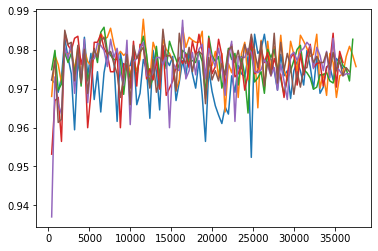

In [12]:
logs = [log1,log2,log3,log4,log5,log6]
import matplotlib.pyplot as plt
for log in logs:
    print(log.args.loss_mask)
    print(max(log.acc))
    plt.plot(log.step,log.acc,label="ce_loss_x")


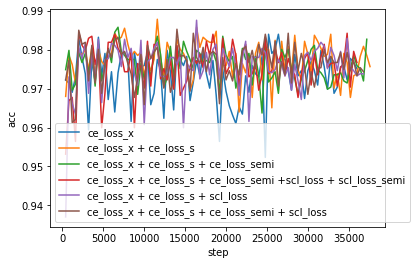

In [17]:
import matplotlib.pyplot as plt
plt.xlabel("step")
plt.ylabel("acc")
plt.plot(log1.step,log1.acc,label="ce_loss_x")
plt.plot(log2.step,log2.acc,label="ce_loss_x + ce_loss_s")
plt.plot(log3.step,log3.acc,label="ce_loss_x + ce_loss_s + ce_loss_semi")
plt.plot(log4.step,log4.acc,label="ce_loss_x + ce_loss_s + ce_loss_semi +scl_loss + scl_loss_semi")
plt.plot(log5.step,log5.acc,label="ce_loss_x + ce_loss_s + scl_loss")
plt.plot(log6.step,log6.acc,label="ce_loss_x + ce_loss_s + ce_loss_semi + scl_loss")

plt.legend()


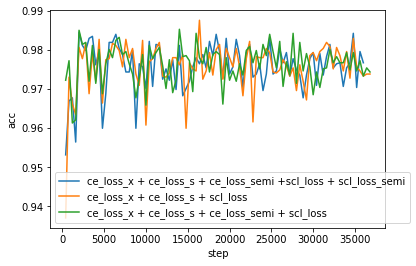

In [16]:
# plt.figure()
plt.xlabel("step")
plt.ylabel("acc")
plt.plot(log4.step,log4.acc,label="ce_loss_x + ce_loss_s + ce_loss_semi +scl_loss + scl_loss_semi")
plt.plot(log5.step,log5.acc,label="ce_loss_x + ce_loss_s + scl_loss")
plt.plot(log6.step,log6.acc,label="ce_loss_x + ce_loss_s + ce_loss_semi + scl_loss")
plt.legend()

In [2]:
import pickle
raw_data = pickle.load(open("dataset/amazon_polarity/raw_data.pkl",'rb'))

In [11]:
for i,item in enumerate(raw_data['test']['neg']):
    if item[1] != 0 and item[1] != 1:
        print("EROOOR")
        print(i)
        break

In [3]:
import scl_data
train_dataset, test_dataset = scl_data.make_dataset(args)

100%|██████████| 199999/199999 [05:27<00:00, 610.48it/s]


In [22]:
for item in test_dataset:
    if item[1].item() != 0 and item[1].item() != 1:
        print("EROOR")
        print(item)
        break

In [26]:
import torch
torch.save([train_dataset, test_dataset],"dataset/amazon_polarity/processed_dataset_1800_test_200K.pkl")

In [3]:
import torch
train_dataset, test_dataset = torch.load("dataset/amazon_polarity/processed_dataset_1800_test_200K.pkl")

In [10]:
test_dataset[4]

(tensor([    0,   100,  3584,    42, 19888,   278,    13,   127,   361,    76,
           793,  1354,     8,    38,     7,  1183,   561,     4,    38,  3996,
            24,    77,    38,    21,    69,  1046,     8,  1064,    11,   657,
            19,     5,   311,     4,    38,   437,  7785,    24,    16,   122,
            15, 19888,    13,   201,     7,   258,  2254,     6,    53,     5,
          1318,     9,     5, 19888,    16,    45,   372,     4,    85,    95,
          1302,   101,    24,   115,    33,  6398, 34367,   357,     4,    20,
          3149,    15,     5,  1012,    34,     7,    28,  1224,    62,   269,
           239,     7,  1798,    24,     4,   635,     6,    24,    18,    45,
            98,  1099,    14,    47,    64,    75,  1183,    24,     6,     8,
            38,    74,   202,  5940,    24,     6,    25,    24,    18,    10,
           182, 24324,  4399,   311,    36,   879,  3341,     5,   924, 25708,
           322,     2,     1,     1,     1,     1,  

In [4]:
!python main_scl.py --steps 1000 --gpu_ids 0 --batch_size 4 --eval_batch_size 64 --num_accum 1 --lr 1e-5 --log_step 90 --log_dir log/run_baseline_360.pkl --dataset_pth dataset/amazon_polarity/processed_dataset_360_test_200K --loss_mask 1,0,0,0,0

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [5]:
!python main_scl.py --steps 1000 --gpu_ids 0 --batch_size 4 --eval_batch_size 64 --num_accum 1 --lr 1e-5 --log_step 90 --log_dir log/run_ce_s_360.pkl --dataset_pth dataset/amazon_polarity/processed_dataset_360_test_200K --loss_mask 1,1,0,0,0

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [6]:
!python main_scl.py --steps 1000 --gpu_ids 1 --batch_size 4 --eval_batch_size 64 --num_accum 1 --lr 1e-5 --log_step 90 --log_dir log/run_all_360.pkl --dataset_pth dataset/amazon_polarity/processed_dataset_360_test_200K --loss_mask 1,1,1,0.1,0.1

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [7]:
!python main_scl.py --steps 1000 --gpu_ids 1 --batch_size 4 --eval_batch_size 64 --num_accum 1 --lr 1e-5 --log_step 90 --log_dir log/run_semi_360.pkl --dataset_pth dataset/amazon_polarity/processed_dataset_360_test_200K --loss_mask 1,1,1,0,0

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [8]:
!python main_scl.py --steps 1000 --gpu_ids 1 --batch_size 4 --eval_batch_size 64 --num_accum 1 --lr 1e-5 --log_step 90 --log_dir log/run_semi_scl_360.pkl --dataset_pth dataset/amazon_polarity/processed_dataset_360_test_200K --loss_mask 1,1,1,0.1,0

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie